<a href="https://colab.research.google.com/github/caltunay/dd_competition_eq_damage_prediction/blob/master/10_09_batch_normalization%20%26%20keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

In [0]:
test_vals = '/content/drive/My Drive/Colab Notebooks/Data/Competition - DrivenData - Earthquake Damage Prediction/test_values.csv'

train_vals = '/content/drive/My Drive/Colab Notebooks/Data/Competition - DrivenData - Earthquake Damage Prediction/train_values.csv'
train_labs = '/content/drive/My Drive/Colab Notebooks/Data/Competition - DrivenData - Earthquake Damage Prediction/train_labels.csv'

In [0]:
temp_df = pd.read_csv(train_vals)

level2mean = temp_df['geo_level_2_id'].map(geo2dict).mean()
level3mean = temp_df['geo_level_3_id'].map(geo3dict).mean()

In [0]:
level2mean

# 2.2382723013341637

2.2382723013343697

In [0]:
# preprocess regularly
# feature engineer 
# tts
# upsample training set only

# add batch normalization for keras
# earlystopping and checkpoint 

In [0]:
all = pd.merge(left = pd.read_csv(train_vals), right = pd.read_csv(train_labs), on = 'building_id', how = 'inner')

all.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [0]:
cats = all.select_dtypes('object').columns.tolist()

all_dum = pd.get_dummies(data = all, columns = cats, prefix_sep = '_', drop_first = True)

In [0]:
cont_vals = all_dum.drop(labels = 'building_id damage_grade geo_level_1_id geo_level_2_id geo_level_3_id'.split(), axis = 1).nunique()[all_dum.drop(labels = 'building_id damage_grade geo_level_1_id geo_level_2_id geo_level_3_id'.split(), axis = 1).nunique()>2].sort_values(ascending = False).index.tolist()

In [0]:
all_dum[cont_vals].head()

,area_percentage,age,height_percentage,count_families,count_floors_pre_eq
0,6,30,5,1,2
1,8,10,7,1,2
2,5,10,5,1,2
3,6,10,5,1,2
4,8,30,9,1,3


In [0]:
all_dum[cont_vals].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 5 columns):
area_percentage        260601 non-null int64
age                    260601 non-null int64
height_percentage      260601 non-null int64
count_families         260601 non-null int64
count_floors_pre_eq    260601 non-null int64
dtypes: int64(5)
memory usage: 11.9 MB


In [0]:
all_dum = pd.get_dummies(data = all_dum, columns = ['count_families','count_floors_pre_eq'], drop_first = True)

In [0]:
all_dum[cont_vals].describe().T

,count,mean,std,min,25%,50%,75%,max
area_percentage,260601.0,8.018051,4.392231,1.0,5.0,7.0,9.0,100.0
age,260601.0,26.535029,73.565937,0.0,10.0,15.0,30.0,995.0
height_percentage,260601.0,5.434365,1.918418,2.0,4.0,5.0,6.0,32.0
count_families,260601.0,0.983949,0.418389,0.0,1.0,1.0,1.0,9.0
count_floors_pre_eq,260601.0,2.129723,0.727665,1.0,2.0,2.0,2.0,9.0


In [0]:
# age cannot be 995, these would be NA values,
# can assign age buckets with creating a dictionary or re-bin age again

In [0]:
series_age, bins_age = pd.qcut(x = all_dum['age'], q = 4, labels = 'new young average old'.split(), retbins =True)

series_age.rename('age_bins', inplace = True)

In [0]:
series_area, bins_area = pd.qcut(all_dum['area_percentage'], q = 3, retbins = True, labels = 'small average large'.split())

series_area.rename('area_bins', inplace = True)

In [0]:
series_height, bins_height = pd.qcut(all_dum['height_percentage'], q = 3, retbins = True, labels = 'small average large'.split())

series_height.rename('height_bins', inplace = True)
bins_height

array([ 2.,  5.,  6., 32.])

In [0]:
all_dum = pd.concat([all_dum, series_age, series_area, series_height], axis = 1)

In [0]:
all_dum = pd.get_dummies(data = all_dum, columns = ['age_bins', 'area_bins', 'height_bins'], drop_first = True)

In [0]:
all_dum = all_dum.drop(labels = ['area_percentage','height_percentage','age'], axis = 1)

In [0]:
all_dum.nunique().sort_values()

In [0]:
# target encode the geo level things

geo1dict = all_dum.groupby('geo_level_1_id').mean()['damage_grade'].to_dict()
geo2dict = all_dum.groupby('geo_level_2_id').mean()['damage_grade'].to_dict()
geo3dict = all_dum.groupby('geo_level_3_id').mean()['damage_grade'].to_dict()

In [0]:
all_dum['geo_level_1_id'].head()

0     6
1     8
2    21
3    22
4    11
Name: geo_level_1_id, dtype: int64

In [0]:
geo1dict

In [0]:
all_dum['geo_level_1_id'] = all_dum['geo_level_1_id'].map(geo1dict)
all_dum['geo_level_2_id'] = all_dum['geo_level_2_id'].map(geo2dict)
all_dum['geo_level_3_id'] = all_dum['geo_level_3_id'].map(geo3dict)

In [0]:
all_dum.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_o,land_surface_condition_t,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_q,...,other_floor_type_x,position_o,position_s,position_t,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,count_families_1,count_families_2,count_families_3,count_families_4,count_families_5,count_families_6,count_families_7,count_families_8,count_families_9,count_floors_pre_eq_2,count_floors_pre_eq_3,count_floors_pre_eq_4,count_floors_pre_eq_5,count_floors_pre_eq_6,count_floors_pre_eq_7,count_floors_pre_eq_8,count_floors_pre_eq_9,age_bins_young,age_bins_average,age_bins_old,area_bins_average,area_bins_large,height_bins_average,height_bins_large
0,802906,2.161724,2.740741,2.837838,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,28830,2.485273,2.487437,2.062500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2,94947,2.563369,2.518750,2.580882,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,590882,2.000960,2.107317,2.096774,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,201944,2.337713,2.348748,2.368852,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1


In [0]:
# submis = pd.read_csv(test_vals)
# submis_dum = pd.get_dummies(data = submis, columns = cats, prefix_sep = '_', drop_first = True)


# submis_dum = pd.get_dummies(data = submis_dum, columns = ['count_families','count_floors_pre_eq'], drop_first = True)


# submis_age_series = pd.cut(x = submis_dum['age'], bins = bins_age, labels = 'new young average old'.split(), include_lowest = True)
# submis_age_series.rename('age_bins', inplace=True)

# submis_area_series = pd.cut(x = submis_dum['area_percentage'], bins = bins_area, labels = 'small average large'.split(), include_lowest = True)
# submis_area_series.rename('area_bins', inplace = True)

# submis_height_series = pd.cut(x = submis_dum['height_percentage'], bins = bins_height, labels = 'small average large'.split(), include_lowest = True)
# submis_height_series.rename('height_bins', inplace = True)

# submis_dum = pd.concat([submis_dum, submis_age_series, submis_area_series, submis_height_series], axis = 1)

# submis_dum = submis_dum.drop(labels = 'age area_percentage height_percentage'.split(), axis = 1)




# submis_dum['geo_level_1_id'] = submis_dum['geo_level_1_id'].map(geo1dict)
# submis_dum['geo_level_2_id'] = submis_dum['geo_level_2_id'].map(geo2dict)
# submis_dum['geo_level_3_id'] = submis_dum['geo_level_3_id'].map(geo3dict)

# submis_dum[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].isnull().sum()

# submis_dum['geo_level_2_id'] = submis_dum['geo_level_2_id'].replace(np.nan, level2mean)
# submis_dum['geo_level_3_id'] = submis_dum['geo_level_3_id'].replace(np.nan, level3mean)


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
ssx = StandardScaler()

In [0]:
# submis = pd.read_csv(test_vals)
# submis_dum = pd.get_dummies(data = submis, columns = cats, prefix_sep = '_', drop_first = True)


# submis_dum = pd.get_dummies(data = submis_dum, columns = ['count_families','count_floors_pre_eq'], drop_first = True)


# submis_age_series = pd.cut(x = submis_dum['age'], bins = bins_age, labels = 'new young average old'.split(), include_lowest = True)
# submis_age_series.rename('age_bins', inplace=True)

# submis_area_series = pd.cut(x = submis_dum['area_percentage'], bins = bins_area, labels = 'small average large'.split(), include_lowest = True)
# submis_area_series.rename('area_bins', inplace = True)

# submis_height_series = pd.cut(x = submis_dum['height_percentage'], bins = bins_height, labels = 'small average large'.split(), include_lowest = True)
# submis_height_series.rename('height_bins', inplace = True)

# submis_dum = pd.concat([submis_dum, submis_age_series, submis_area_series, submis_height_series], axis = 1)

# submis_dum = submis_dum.drop(labels = 'age area_percentage height_percentage'.split(), axis = 1)




# submis_dum['geo_level_1_id'] = submis_dum['geo_level_1_id'].map(geo1dict)
# submis_dum['geo_level_2_id'] = submis_dum['geo_level_2_id'].map(geo2dict)
# submis_dum['geo_level_3_id'] = submis_dum['geo_level_3_id'].map(geo3dict)

# submis_dum[['geo_level_1_id','geo_level_2_id','geo_level_3_id']].isnull().sum()

# submis_dum['geo_level_2_id'] = submis_dum['geo_level_2_id'].replace(np.nan, level2mean)
# submis_dum['geo_level_3_id'] = submis_dum['geo_level_3_id'].replace(np.nan, level3mean)



# submis_dum = pd.get_dummies(data = submis_dum, columns = ['age_bins','area_bins','height_bins'], drop_first = True)

In [0]:
scaled_submis_df = pd.DataFrame(ssx.transform(submis_dum[scale]), columns = scale)
remainder_submis_df = submis_dum.drop(labels = scale, axis = 1)

submis_clean = pd.concat([remainder_submis_df, scaled_submis_df], axis = 1)
submis_clean.head()

,building_id,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition_o,land_surface_condition_t,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_o,position_s,position_t,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,count_families_1,count_families_2,count_families_3,count_families_4,count_families_5,count_families_6,count_families_7,count_families_8,count_floors_pre_eq_2,count_floors_pre_eq_3,count_floors_pre_eq_4,count_floors_pre_eq_5,count_floors_pre_eq_6,count_floors_pre_eq_7,count_floors_pre_eq_8,age_bins_young,age_bins_average,age_bins_old,area_bins_average,area_bins_large,height_bins_average,height_bins_large,geo_level_3_id,geo_level_2_id,geo_level_1_id
0,300051,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0.985618,1.304617,1.934396
1,99355,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,-0.597105,-0.160494,-0.266221
2,890251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.908874,-0.176848,-0.825332
3,745817,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-2.005997,-1.973508,-1.764600
4,421793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,1.466642,1.260130,1.934396


In [0]:
to_add1 = np.zeros(len(submis_clean)).tolist()
to_add2 = np.zeros(len(submis_clean)).tolist()

In [0]:
submis_clean['count_families_9'] = to_add1
submis_clean['count_floors_pre_eq_9'] = to_add1


In [0]:
col_order = clean_df.drop(labels = 'damage_grade', axis = 1).columns.tolist()

In [0]:
submis_clean_final = submis_clean[col_order]

In [0]:
tot = 0

for tr, te in zip(clean_df.drop(labels = 'damage_grade', axis = 1).columns, submis_clean_final):
    if tr != te:
        tot += 1
    else:
        0

In [0]:
tot

0

In [0]:
clean_df.drop(labels = 'damage_grade', axis =1).shape

(260601, 80)

In [0]:
# all_dum.nunique().sort_values(ascending = False)

scale = 'geo_level_3_id geo_level_2_id geo_level_1_id'.split()

scaled_df = pd.DataFrame(ssx.fit_transform(all_dum[scale]), columns = scale)
remainder_df = all_dum.drop(labels = scale, axis = 1)

clean_df = pd.concat([remainder_df, scaled_df], axis = 1)

clean_df.head()

,building_id,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_o,land_surface_condition_t,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_o,...,position_t,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,count_families_1,count_families_2,count_families_3,count_families_4,count_families_5,count_families_6,count_families_7,count_families_8,count_families_9,count_floors_pre_eq_2,count_floors_pre_eq_3,count_floors_pre_eq_4,count_floors_pre_eq_5,count_floors_pre_eq_6,count_floors_pre_eq_7,count_floors_pre_eq_8,count_floors_pre_eq_9,age_bins_young,age_bins_average,age_bins_old,area_bins_average,area_bins_large,height_bins_average,height_bins_large,geo_level_3_id,geo_level_2_id,geo_level_1_id
0,802906,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.502499,1.404413,-0.266221
1,28830,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,-0.440482,0.696423,0.859024
2,94947,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.858574,0.783943,1.130630
3,590882,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.354591,-0.366024,-0.825332
4,201944,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0.327231,0.308782,0.345837


In [0]:
y = pd.get_dummies(data = clean_df[['damage_grade']], columns = ['damage_grade'])

x = clean_df.drop(labels = ['building_id', 'damage_grade'], axis =1)

In [0]:
submis_arr = submis_clean_final.drop(labels = 'building_id', axis = 1).values

In [0]:
from sklearn.model_selection import train_test_split as tts

In [0]:
x_train, x_test, y_train, y_test = tts(x,y,stratify = y, test_size = .275, random_state =42)

In [0]:
y_train_keras = y_train.values
y_test_keras = y_test.values

x_train_keras = x_train.values
x_test_keras = x_test.values

In [0]:
el2 = []

for i in range(len(x.nunique()[x.nunique() == 2])):
    el2.append(i) 

In [0]:
len(el2)

76

In [0]:
len(x.nunique()[x.nunique() == 2])

76

In [0]:
sme = SMOTENC(random_state = 42, categorical_features = el2)

In [0]:
x_train_resampled, x_test_resampled = sme.fit_resample(x_train, y_train)

KeyboardInterrupt: ignored

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [0]:
x_keras = x.values
y_keras = y.values

In [0]:
monitor_val = EarlyStopping(monitor = 'val_acc', patience = 5)

In [0]:
model = Sequential()

model.add(Dense(output_dim = 41, input_dim = 79, init = 'normal', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(output_dim = 41, activation = 'relu'))

model.add(BatchNormalization())
model.add(Dense(output_dim = 41, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(output_dim = 3, activation = 'softmax'))

model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

model.fit(x_train_keras, y_train_keras, validation_data = (x_test_keras, y_test_keras), epochs = 1000, batch_size = 13000, callbacks = [monitor_val])


In [0]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import f1_score

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from keras.optimizers import Adam

In [0]:
def create_model(activation='relu'):
    
    # set optimizer
#     opt = Adam(lr=learning_rate)
  	
  	# Create your binary classification model  
    model = Sequential()
    
    model.add(Dense(output_dim = n1, input_shape=(79,), activation=activation))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation=activation))
    model.add(BatchNormalization())
    
    model.add(Dense(3, activation='softmax'))
  	
  	# Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
wrapped_model = KerasClassifier(build_fn = create_model)

# hyperparameters
params = {'activation':['relu','tanh'], 
          'batch_size':[5000,13000,26000],
          'epochs':[50,100,200])#, 
#          'learning_rate':[.1,.01,.001]}


# Create a randomize search cv object and fit it on the data to obtain the results
random_search = RandomizedSearchCV(wrapped_model, param_distributions=params, cv=KFold(5))


random_search.fit(x.values,y.values)

# kfolds = cross_val_score(model, X, y, cv=3)

SyntaxError: ignored

In [0]:
from imblearn.over_sampling import SMOTENC

In [0]:
smnc = SMOTENC(categorical_features = el2, random_state = 42)

In [0]:
y1 = all_dum['damage_grade'].values

In [0]:
x_resampled, y_resampled = smnc.fit_resample(x,y1)

In [0]:
x_resampled.shape

(444777, 79)

In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

stopper = EarlyStopping(monitor = 'val_acc', patience = 8)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
scores2 = []

# x_t = all_dum.drop(labels = 'building_id damage_grade'.split(), axis = 1).values #x.values
# y_t = all_dum['damage_grade'].values #y.values

for train, test in kfold.split(x_resampled, y_resampled): 

    # convert y  to one hot encoded
    temp_y = pd.get_dummies(pd.DataFrame(y_resampled),columns = [0]).values
    
    
    # create model
    clf = Sequential()
    
    clf.add(Dense(output_dim = 128, input_dim = 79, activation = 'relu', init = 'uniform'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 128, activation = 'relu'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 128, activation = 'relu'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 128, activation = 'relu'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 3, activation = 'softmax'))
    
    # Compile model
    clf.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

    # Fit the model
    clf.fit(x_resampled[train], temp_y[train], validation_data = (x_resampled[test], temp_y[test]), epochs = 1500, batch_size = 25000, verbose = 1, callbacks = [stopper])

    # make prediction, get idxmax, evaluate against test set
    y_pred = pd.DataFrame(clf.predict(x_resampled[test]), columns = [1,2,3]).idxmax(axis = 1)
    
    temp_score = round(f1_score(y_resampled[test], y_pred, average = 'micro'), 2)
    
    scores2.append(temp_score)  
    
print(scores2)
print(np.mean(scores2))


In [0]:
damage_grade = pd.DataFrame(clf.predict(submis_arr), columns = [1,2,3]).idxmax(axis = 1)

In [0]:
pd.concat([submis_clean_final['building_id'],damage_grade], axis = 1).set_index('building_id').rename({0:'damage_grade'}, axis =1).to_csv('submis_df3.csv')

In [0]:
# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

stopper = EarlyStopping(monitor = 'val_acc', patience = 5)

# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)
scores2 = []

x_t = all_dum.drop(labels = 'building_id damage_grade'.split(), axis = 1).values #x.values
y_t = all_dum['damage_grade'].values #y.values

for train, test in kfold.split(x_t, y_t): 

    # convert y  to one hot encoded
    temp_y = pd.get_dummies(pd.DataFrame(y_t),columns = [0]).values
    
    
    # create model
    clf = Sequential()
    
    clf.add(Dense(output_dim = 128, input_dim = 79, activation = 'relu', init = 'normal'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 128, activation = 'relu'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 128, activation = 'relu'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 128, activation = 'relu'))
    clf.add(BatchNormalization())
    
    clf.add(Dense(output_dim = 3, activation = 'softmax'))
    
    # Compile model
    clf.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

    # Fit the model
    clf.fit(x_t[train], temp_y[train], validation_data = (x_t[test], temp_y[test]), epochs = 1500, batch_size = 25000, verbose = 1, callbacks = [stopper])

    # make prediction, get idxmax, evaluate against test set
    y_pred = pd.DataFrame(clf.predict(x_t[test]), columns = [1,2,3]).idxmax(axis = 1)
    
    temp_score = round(f1_score(y_t[test], y_pred, average = 'micro'), 2)
    
    scores2.append(temp_score)  
    
print(scores2)
print(np.mean(scores2))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=79, activation="relu", units=128, kernel_initializer="normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`


Train on 195450 samples, validate on 65151 samples
Epoch 1/1500
195450/195450 [==============================] - 23s 119us/step - loss: 1.1019 - acc: 0.5428 - val_loss: 1.1503 - val_acc: 0.5881
Epoch 2/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.7985 - acc: 0.6982 - val_loss: 1.2270 - val_acc: 0.6318
Epoch 3/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.7270 - acc: 0.7296 - val_loss: 1.0391 - val_acc: 0.6751
Epoch 4/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.6905 - acc: 0.7382 - val_loss: 0.8429 - val_acc: 0.7063
Epoch 5/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.6661 - acc: 0.7422 - val_loss: 0.7445 - val_acc: 0.7227
Epoch 6/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.6478 - acc: 0.7460 - val_loss: 0.6951 - val_acc: 0.7297
Epoch 7/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.6324 - acc: 0.7489 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=79, activation="relu", units=128, kernel_initializer="normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`


Train on 195450 samples, validate on 65151 samples
Epoch 1/1500
195450/195450 [==============================] - 23s 119us/step - loss: 1.1579 - acc: 0.5047 - val_loss: 1.1287 - val_acc: 0.5389
Epoch 2/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.8431 - acc: 0.6594 - val_loss: 1.1931 - val_acc: 0.5736
Epoch 3/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.7523 - acc: 0.7127 - val_loss: 1.2561 - val_acc: 0.6027
Epoch 4/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.7056 - acc: 0.7300 - val_loss: 0.9621 - val_acc: 0.6755
Epoch 5/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.6759 - acc: 0.7375 - val_loss: 0.7910 - val_acc: 0.7151
Epoch 6/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.6542 - acc: 0.7435 - val_loss: 0.7225 - val_acc: 0.7271
Epoch 7/1500
195450/195450 [==============================] - 0s 2us/step - loss: 0.6373 - acc: 0.7466 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=79, activation="relu", units=128, kernel_initializer="normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`


Train on 195451 samples, validate on 65150 samples
Epoch 1/1500
195451/195451 [==============================] - 24s 121us/step - loss: 1.1100 - acc: 0.5306 - val_loss: 1.1954 - val_acc: 0.5762
Epoch 2/1500
195451/195451 [==============================] - 0s 2us/step - loss: 0.8105 - acc: 0.6851 - val_loss: 1.1033 - val_acc: 0.6353
Epoch 3/1500
195451/195451 [==============================] - 0s 2us/step - loss: 0.7348 - acc: 0.7237 - val_loss: 0.9884 - val_acc: 0.6895
Epoch 4/1500
195451/195451 [==============================] - 0s 2us/step - loss: 0.6966 - acc: 0.7346 - val_loss: 0.8104 - val_acc: 0.7188
Epoch 5/1500
195451/195451 [==============================] - 0s 2us/step - loss: 0.6720 - acc: 0.7396 - val_loss: 0.7584 - val_acc: 0.7263
Epoch 6/1500
195451/195451 [==============================] - 0s 2us/step - loss: 0.6535 - acc: 0.7445 - val_loss: 0.7133 - val_acc: 0.7316
Epoch 7/1500
195451/195451 [==============================] - 0s 2us/step - loss: 0.6382 - acc: 0.7464 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=79, activation="relu", units=128, kernel_initializer="normal")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=128)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=3)`


Train on 195452 samples, validate on 65149 samples
Epoch 1/1500
195452/195452 [==============================] - 24s 122us/step - loss: 1.1352 - acc: 0.5184 - val_loss: 1.1430 - val_acc: 0.5694
Epoch 2/1500
195452/195452 [==============================] - 0s 2us/step - loss: 0.8148 - acc: 0.6841 - val_loss: 1.0838 - val_acc: 0.6454
Epoch 3/1500
195452/195452 [==============================] - 0s 2us/step - loss: 0.7364 - acc: 0.7218 - val_loss: 0.9934 - val_acc: 0.6783
Epoch 4/1500
195452/195452 [==============================] - 0s 2us/step - loss: 0.6968 - acc: 0.7338 - val_loss: 0.8285 - val_acc: 0.7123
Epoch 5/1500
195452/195452 [==============================] - 0s 2us/step - loss: 0.6712 - acc: 0.7389 - val_loss: 0.7369 - val_acc: 0.7270
Epoch 6/1500
195452/195452 [==============================] - 0s 2us/step - loss: 0.6519 - acc: 0.7425 - val_loss: 0.6897 - val_acc: 0.7349
Epoch 7/1500
195452/195452 [==============================] - 0s 2us/step - loss: 0.6361 - acc: 0.7453 - v

In [0]:
# pd.pivot_table(data = pd.concat([all_dum,series_height], axis = 1), index = 'height_bins', aggfunc = 'count', columns = 'damage_grade' ) #pd.concat([all_dum,series_height], axis = 1)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

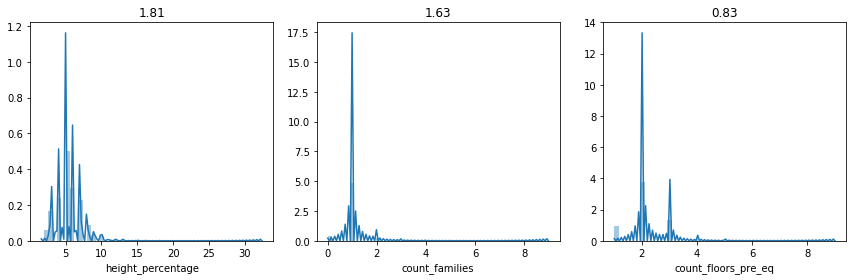

In [0]:
plt.figure(figsize = (12,4))
n=1
for col in 'height_percentage count_families count_floors_pre_eq'.split():
    
    plt.subplot(1,3,n)
    sns.distplot(all_dum[col])
    plt.title(str(all_dum[col].skew().round(2)))
    n+=1
    
plt.tight_layout()
plt.show();

In [0]:
for col in 'height_percentage count_families count_floors_pre_eq'.split():
    all_dum[col] = np.log1p(all_dum[col])

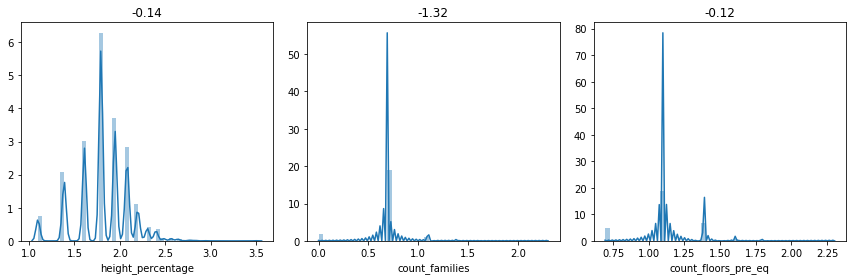

In [0]:
plt.figure(figsize = (12,4))
n=1
for col in 'height_percentage count_families count_floors_pre_eq'.split():
    
    plt.subplot(1,3,n)
    sns.distplot(all_dum[col])
    plt.title(str(all_dum[col].skew().round(2)))
    n+=1
    
plt.tight_layout()
plt.show();

In [0]:
for col in 'height_percentage count_families count_floors_pre_eq'.split():
    all_dum[col] = np.expm1(all_dum[col])

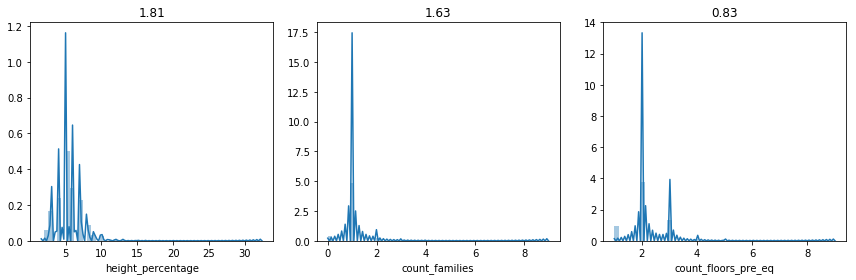

In [0]:
plt.figure(figsize = (12,4))
n=1
for col in 'height_percentage count_families count_floors_pre_eq'.split():
    
    plt.subplot(1,3,n)
    sns.distplot(all_dum[col])
    plt.title(str(all_dum[col].skew().round(2)))
    n+=1
    
plt.tight_layout()
plt.show();

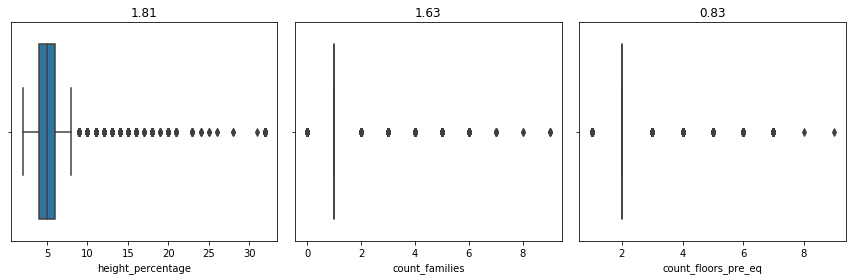

In [0]:
plt.figure(figsize = (12,4))
n=1
for col in 'height_percentage count_families count_floors_pre_eq'.split():
    
    plt.subplot(1,3,n)
    sns.boxplot(all_dum[col])
    plt.title(str(all_dum[col].skew().round(2)))
    n+=1
    
plt.tight_layout()
plt.show();

In [0]:
all_dum[['count_families', 'count_floors_pre_eq']].nunique()

count_families         10
count_floors_pre_eq     9
dtype: int64

In [0]:
all_dum = pd.get_dummies(data = all_dum, columns=  ['count_families', 'count_floors_pre_eq'], drop_first = True )

In [0]:
all_dum.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_o,land_surface_condition_t,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_q,roof_type_x,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_o,position_s,position_t,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w,count_families_1.0,count_families_1.9999999999999996,count_families_3.0,count_families_3.9999999999999996,count_families_5.0,count_families_6.0,count_families_6.999999999999998,count_families_8.000000000000002,count_families_9.000000000000002,count_floors_pre_eq_1.9999999999999996,count_floors_pre_eq_3.0,count_floors_pre_eq_3.9999999999999996,count_floors_pre_eq_5.0,count_floors_pre_eq_6.0,count_floors_pre_eq_6.999999999999998,count_floors_pre_eq_8.000000000000002,count_floors_pre_eq_9.000000000000002
0,802906,6,487,12198,30,6,5.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,28830,8,900,2812,10,8,7.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,94947,21,363,8973,10,5,5.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,590882,22,418,10694,10,6,5.0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,201944,11,131,1488,30,8,9.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [0]:
# test_series = all['height_percentage'].copy()

# test_series = np.log1p(test_series)

# series_height, bins_height = pd.qcut(x = test_series, q = 2, retbins = True, labels = 'single more'.split())
# series_height.rename('height_binned', inplace = True)

# pd.concat([all,series_height], axis = 1).groupby('height_binned').mean()['damage_grade']
# # series_height = pd.cut(x = all['height_percentage'], bins = [0.0, 5.0, 15.0, 30.0, 100.0], labels = ['new', 'young', 'old', 'ancient'], include_lowest = True)
# # series_age

height_binned
single    2.205288
more      2.284102
Name: damage_grade, dtype: float64

Text(0.5, 1.0, '-0.14097914576002213')

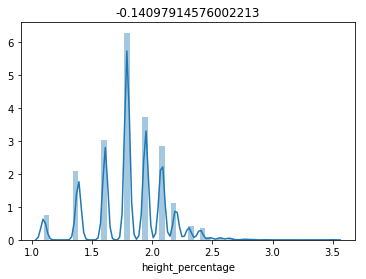

In [0]:
import seaborn as sns 
import matplotlib.pyplot as plt 

sns.distplot(test_series)
plt.title(test_series.skew())

In [0]:
# area_pct 100 sounds off

# series_area, bins_area = pd.qcut(x = all['area_percentage'], q = 4, retbins = True, labels = 'small average large huge'.split())
# series_area.rename('area_pct_binned', inplace = True)

series_area = pd.cut(x = all['area_percentage'], bins = [1.0, 5.0, 9.0, 100.0], labels = ['small', 'average', 'large'], include_lowest = True)
series_area.rename('area_pct_binned', inplace = True)

series_age = pd.cut(x = all['age'], bins = [0.0, 5.0, 15.0, 30.0, 100.0], labels = ['new', 'young', 'old', 'ancient'], include_lowest = True)
series_age.rename('age_binned', inplace = True)


# will only nplog1- height
# series_height, bins_height = pd.qcut(x = all['height_percentage'], q = 4, retbins = True, labels = 'flat mid tall huge'.split())
# series_height.rename('height_binned', inplace = True)

In [0]:
# t = np.clip(all['age'], a_min = all['age'].min(), a_max = all['age'].quantile(.95))
# t.describe()

all_bins = pd.concat([all, series_area, series_age], axis = 1)

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

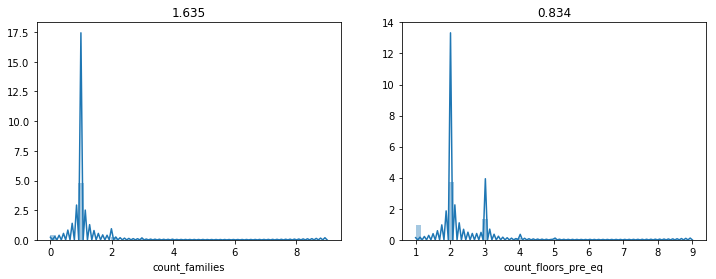

In [0]:
n = 1
plt.figure(figsize = (12,4))
for col in ['count_families', 'count_floors_pre_eq']:
    
    plt.subplot(1,2,n)
    sns.distplot(all_bins[col])
    plt.title(all_bins[col].skew().round(3))
    n+=1

In [0]:
all_bins['count_families'] = np.log1p(all_bins['count_families'])
all_bins['count_floors_pre_eq'] = np.log1p(all_bins['count_floors_pre_eq'])
all_bins['height_percentage'] = np.log1p(all_bins['height_percentage'])

In [0]:
all_bins = all_bins.drop(labels = ['age', 'area_percentage'], axis = 1)

In [0]:
geo_1_map = all_bins.groupby('geo_level_1_id').mean()['damage_grade'].to_dict()
geo_2_map = all_bins.groupby('geo_level_2_id').mean()['damage_grade'].to_dict()
geo_3_map = all_bins.groupby('geo_level_3_id').mean()['damage_grade'].to_dict()

In [0]:
all_bins['geo_level_1_id'] = all_bins['geo_level_1_id'].map(geo_1_map)
all_bins['geo_level_2_id'] = all_bins['geo_level_2_id'].map(geo_2_map)
all_bins['geo_level_3_id'] = all_bins['geo_level_3_id'].map(geo_3_map)

In [0]:
to_dum2 = 'area_pct_binned age_binned'.split()

all_bins = pd.get_dummies(data = all_bins, columns = to_dum2, prefix_sep = '|', drop_first = True)

In [0]:
all_bins.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition|o,land_surface_condition|t,foundation_type|i,foundation_type|r,foundation_type|u,foundation_type|w,roof_type|q,roof_type|x,ground_floor_type|m,ground_floor_type|v,ground_floor_type|x,ground_floor_type|z,other_floor_type|q,other_floor_type|s,other_floor_type|x,position|o,position|s,position|t,plan_configuration|c,plan_configuration|d,plan_configuration|f,plan_configuration|m,plan_configuration|n,plan_configuration|o,plan_configuration|q,plan_configuration|s,plan_configuration|u,legal_ownership_status|r,legal_ownership_status|v,legal_ownership_status|w,area_pct_binned|average,area_pct_binned|large,age_binned|young,age_binned|old,age_binned|ancient
0,802906,2.161724,2.740741,2.837838,1.098612,1.791759,1,1,0,0,0,0,0,0,0,0,0,0.693147,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
1,28830,2.485273,2.487437,2.062500,1.098612,2.079442,0,1,0,0,0,0,0,0,0,0,0,0.693147,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
2,94947,2.563369,2.518750,2.580882,1.098612,1.791759,0,1,0,0,0,0,0,0,0,0,0,0.693147,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,590882,2.000960,2.107317,2.096774,1.098612,1.791759,0,1,0,0,0,0,1,1,0,0,0,0.693147,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
4,201944,2.337713,2.348748,2.368852,1.386294,2.302585,1,0,0,0,0,0,0,0,0,0,0,0.693147,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0


In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
ssx = StandardScaler()

In [0]:
all_bins.drop(labels = ['building_id', 'damage_grade'], axis = 1).nunique().sort_values(ascending = False).index[:6].tolist()

['geo_level_3_id',
 'geo_level_2_id',
 'geo_level_1_id',
 'height_percentage',
 'count_families',
 'count_floors_pre_eq']

In [0]:
scaled_cols = all_bins.drop(labels = ['building_id', 'damage_grade'], axis = 1).nunique().sort_values(ascending = False).index[:6].tolist()

df_scale = all_bins[scaled_cols]
df_remainder = all_bins.drop(labels = scaled_cols, axis = 1)

df_scale = pd.DataFrame(ssx.fit_transform(df_scale), columns = scaled_cols)

all_clean = pd.concat([df_remainder, df_scale], axis = 1)

**Submission DF PreProcessing**

In [0]:
submis_eq = pd.get_dummies(data = pd.read_csv(test_vals), columns = to_dum, prefix_sep = '|', drop_first = True)



submis_eq.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition|o,land_surface_condition|t,foundation_type|i,foundation_type|r,foundation_type|u,foundation_type|w,roof_type|q,roof_type|x,ground_floor_type|m,ground_floor_type|v,ground_floor_type|x,ground_floor_type|z,other_floor_type|q,other_floor_type|s,other_floor_type|x,position|o,position|s,position|t,plan_configuration|c,plan_configuration|d,plan_configuration|f,plan_configuration|m,plan_configuration|n,plan_configuration|o,plan_configuration|q,plan_configuration|s,plan_configuration|u,legal_ownership_status|r,legal_ownership_status|v,legal_ownership_status|w
0,300051,17,596,11307,3,20,7,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
1,99355,6,141,11987,2,25,13,5,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
2,890251,22,19,10044,2,5,4,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
3,745817,26,39,633,1,0,19,3,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0
4,421793,17,289,7970,3,15,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0


In [0]:
# series_area = pd.cut(x = all['area_percentage'], bins = [1.0, 5.0, 9.0, 100.0], labels = ['small', 'average', 'large'], include_lowest = True)
# series_area.rename('area_pct_binned', inplace = True)

# series_age = pd.cut(x = all['age'], bins = [0.0, 5.0, 15.0, 30.0, 100.0], labels = ['new', 'young', 'old', 'ancient'], include_lowest = True)
# series_age.rename('age_binned', inplace = True)



test_series_area = pd.cut(x = submis_eq['area_percentage'], bins = [1.0, 5.0, 9.0, 100.0], labels = ['small', 'average', 'large'], include_lowest = True)
test_series_area.rename('area_pct_binned', inplace = True)

test_series_age = pd.cut(x = submis_eq['age'], bins = [0.0, 5.0, 15.0, 30.0, 100.0], labels = ['new', 'young', 'old', 'ancient'], include_lowest = True)
test_series_age.rename('age_binned', inplace = True)


# Height needs np.log1p 

# test_series_height = pd.cut(x = submis_eq['height_percentage'], bins = bins_height, labels = 'flat mid tall huge'.split(), include_lowest = True)
# test_series_height.rename('height_binned', inplace = True)

In [0]:
submis_eq_dums = pd.concat([submis_eq, test_series_area, test_series_age], axis = 1)

submis_eq_dums = pd.get_dummies(data = submis_eq_dums, columns = to_dum2, prefix_sep = '|', drop_first = True)

In [0]:
submis_eq_dums = submis_eq_dums.drop(labels = 'age area_percentage'.split(), axis = 1)

In [0]:
submis_eq_dums['geo_level_1_id'] = submis_eq_dums['geo_level_1_id'].map(geo_1_map)
submis_eq_dums['geo_level_2_id'] = submis_eq_dums['geo_level_2_id'].map(geo_2_map)
submis_eq_dums['geo_level_3_id'] = submis_eq_dums['geo_level_3_id'].map(geo_3_map)

In [0]:
submis_eq_dums.isnull().sum().sort_values(ascending = False)

In [0]:
submis_eq_dums['geo_level_2_id'] = submis_eq_dums['geo_level_2_id'].fillna(value = submis_eq_dums['geo_level_2_id'].mean())

submis_eq_dums['geo_level_3_id'] = submis_eq_dums['geo_level_3_id'].fillna(value = submis_eq_dums['geo_level_3_id'].mean())

In [0]:
submis_eq_dums.isnull().sum().sum()

0

In [0]:
submis_eq_dums['count_families'] = np.log1p(submis_eq_dums['count_families'])
submis_eq_dums['count_floors_pre_eq'] = np.log1p(submis_eq_dums['count_floors_pre_eq'])
submis_eq_dums['height_percentage'] = np.log1p(submis_eq_dums['height_percentage'])

In [0]:
# scaled_cols = all_bins.drop(labels = ['building_id', 'damage_grade'], axis = 1).nunique().sort_values(ascending = False).index[:5].to_list()

# df_scale = all_bins[scaled_cols]
# df_remainder = all_bins.drop(labels = scaled_cols, axis = 1)

# df_scale = pd.DataFrame(ssx.fit_transform(df_scale), columns = scaled_cols)

# all_clean = pd.concat([df_remainder, df_scale], axis = 1)


submis_scaled = submis_eq_dums[scaled_cols]
submis_remainder = submis_eq_dums.drop(labels = scaled_cols, axis = 1)

submis_scaled = pd.DataFrame(ssx.transform(submis_scaled), columns = scaled_cols)
submis_clean = pd.concat([submis_remainder, submis_scaled], axis = 1)

submis_clean.head()

,building_id,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,land_surface_condition|o,land_surface_condition|t,foundation_type|i,foundation_type|r,foundation_type|u,foundation_type|w,roof_type|q,roof_type|x,ground_floor_type|m,ground_floor_type|v,ground_floor_type|x,ground_floor_type|z,other_floor_type|q,other_floor_type|s,other_floor_type|x,position|o,position|s,position|t,plan_configuration|c,plan_configuration|d,plan_configuration|f,plan_configuration|m,plan_configuration|n,plan_configuration|o,plan_configuration|q,plan_configuration|s,plan_configuration|u,legal_ownership_status|r,legal_ownership_status|v,legal_ownership_status|w,area_pct_binned|average,area_pct_binned|large,age_binned|young,age_binned|old,age_binned|ancient,geo_level_3_id,geo_level_2_id,geo_level_1_id,height_percentage,count_families,count_floors_pre_eq
0,300051,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0.985618,1.304617,1.934396,0.435463,0.139372,1.177992
1,99355,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,-0.597105,-0.160494,-0.266221,-0.099082,0.139372,-0.068990
2,890251,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.908874,-0.176848,-0.825332,-0.099082,0.139372,-0.068990
3,745817,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,-2.005997,-1.973508,-1.764600,-1.505104,1.954200,-1.826513
4,421793,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1.466642,1.260130,1.934396,0.898506,0.139372,1.177992


In [0]:
# sns.heatmap(all_clean.drop(labels = 'building_id', axis = 1).corr(), cmap = 'plasma', square = True)

temp_df = pd.DataFrame(all_clean.drop(labels = 'building_id', axis = 1).corr().abs().unstack()).reset_index()


In [0]:
temp2 = temp_df[temp_df[0] != 1].sort_values(by = 0, ascending = False)

temp2[temp2['level_0'] == 'damage_grade']

In [0]:
all_clean.columns.tolist()

**Modelling starts here**

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD, Adam


from sklearn.model_selection import train_test_split as tts, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [0]:
all_clean['damage_grade'].value_counts(normalize = False)

2    148259
3     87218
1     25124
Name: damage_grade, dtype: int64

In [0]:
x = all_clean.drop(labels = 'building_id damage_grade'.split(), axis = 1).values
y_keras = pd.get_dummies(data = all_clean[['damage_grade']], columns = ['damage_grade'], prefix = '', prefix_sep = '')
y_keras.head()

,1,2,3
0,0,0,1
1,0,1,0
2,0,0,1
3,0,1,0
4,0,0,1


In [0]:
x_train, x_test, y_train, y_test = tts(x, y_keras, test_size = .25, random_state = 42)

In [0]:
x_train.shape

(195450, 63)

(195450, 63)

In [0]:
model = Sequential()

model.add(Dense(output_dim = 60, input_dim = 63, activation = 'relu'))
model.add(Dense(output_dim = 90, activation = 'relu'))
# model.add(Dense(output_dim = 90, activation = 'relu'))
model.add(Dense(output_dim = 40, activation = 'relu'))
model.add(Dense(output_dim = 9, activation = 'relu'))
model.add(Dense(output_dim = 3, activation = 'softmax'))

# sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer = Adam(lr = 0.001, decay = 1e-6), metrics = ['accuracy'], loss = 'categorical_crossentropy')

model.fit(x_train, y_train, epochs = 180, batch_size = 13030)

print(classification_report(y_test_t['heart_disease_present'].astype(int), pd.DataFrame(pd.DataFrame(model.predict(x_test),columns = [1,2,3]).idxmax(axis = 1), columns = ['heart_disease_present'])['heart_disease_present'].astype(int)))

In [0]:
# The one that worked out


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)


# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scores2 = []
x_t = x.values
y_t = y.values

for train, test in kfold.split(x_t, y_t): 

    # convert y  to one hot encoded
    temp_y = pd.get_dummies(pd.DataFrame(y_t),columns = [0]).values
    
    
    # create model
    clf = Sequential()
    
    clf.add(Dense(output_dim = 60, input_dim = 53, activation = 'relu', init = 'uniform'))
    clf.add(Dense(output_dim = 60, activation = 'relu'))
    clf.add(Dense(output_dim = 60, activation = 'relu'))
    clf.add(Dense(output_dim = 3, activation = 'softmax'))
    
    # Compile model
    clf.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'categorical_crossentropy')

    # Fit the model
    clf.fit(x_t[train], temp_y[train], epochs = 150, batch_size = 13030, verbose = 1)

    # make prediction, get idxmax, evaluate against test set
    y_pred = pd.DataFrame(clf.predict(x_t[test]), columns = [1,2,3]).idxmax(axis = 1)
    temp_score = round(f1_score(y_t[test], y_pred, average = 'micro'), 2)
    scores2.append(temp_score)  
    
print(scores2)
print(np.mean(scores2))


In [0]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_keras.values, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

d_class_weights

{0: 3.4575306479859895, 1: 0.5859138399692431, 2: 0.9959756013666904}

In [0]:
submis_df = pd.concat([submis_clean['building_id'], pd.DataFrame(pd.DataFrame(model.predict(submis_clean.drop(labels = 'building_id', axis = 1).values), columns = [1,2,3]).idxmax(axis=1), columns = ['damage_grade'])], axis = 1).set_index('building_id')

submis_df.to_csv('submission_eq5.csv')